# Fine-Tuning BERT for Sentence-Pair Classification

This notebook demonstrates how to fine-tune BERT-based models for the sentence-pair classification task. Utilizing the Hugging Face transformers and datasets libraries, this TensorFlow implementation enables seamless research experiments and evaluation metrics.

The sentence-pair classification task is a vital component of the semantic textual similarity/duplicate problem. It involves two pairs of questions, and the goal is to model the textual interaction between them.

## Dataset

The dataset used in this notebook is the Quora Question Pair (QQP) dataset, which is a part of the GLUE benchmark. The dataset consists of pairs of questions, and the objective is to predict whether one sentence is the paraphrase of the other. The evaluation metrics for this task are F1 score and accuracy.

## Main Features

This tutorial offers the following main features:

1. End-to-end ML implementation covering training, validation, prediction, and evaluation.
2. Capability to utilize custom datasets for fine-tuning.
3. Facilitation of quick experiments with other BERT-based models such as BERT, ALBERT, and more.
4. A comparison between the fine-tuned model and the model without fine-tuning.

In [ ]:
!pip install datasets, transformers

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [58]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "qqp", split='train[:50000]')
valid_dataset = load_dataset("glue", "qqp", split="validation[:500]")

In [59]:
train_dataset[0]

{'question1': 'How is the life of a math student? Could you describe your own experiences?',
 'question2': 'Which level of prepration is enough for the exam jlpt5?',
 'label': 0,
 'idx': 0}

In [60]:
train_dataset[1]

{'question1': 'How do I control my horny emotions?',
 'question2': 'How do you control your horniness?',
 'label': 1,
 'idx': 1}

In [61]:
len(train_dataset), len(valid_dataset) 

(50000, 500)

### Model and Tokenizer loading

In [62]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [6]:
# Model set and batch size
model_checkpoint = "nreimers/albert-small-v2"

In [7]:
# Initializing the tokenizer
tokenizer = #Your code

In [133]:
# Downloading the model
num_classes = 2
model = #Your code

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at nreimers/albert-small-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Testing Tokenizer

In [9]:
max_length = 32

In [10]:
# Running tokenizer on sample data
tokenizer(
    text=train_dataset[0]["question1"], 
    text_pair=train_dataset[0]["question2"], 
    padding='max_length', 
    truncation=True, 
    max_length=max_length
)  

{'input_ids': [2, 184, 25, 14, 201, 16, 21, 5057, 1209, 60, 110, 42, 4996, 154, 258, 5513, 3, 56, 662, 16, 15884, 5946, 25, 511, 26, 14, 11796, 487, 5478, 38, 264, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [11]:
tokenizer.special_tokens_map

{'bos_token': '[CLS]',
 'eos_token': '[SEP]',
 'unk_token': '<unk>',
 'sep_token': '[SEP]',
 'pad_token': '<pad>',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [12]:
tokenizer.bos_token_id, tokenizer.eos_token_id, tokenizer.mask_token_id, 

(2, 3, 4)

### Tokenizer for data preprocessing

In [13]:
def preprocess_fn(records):
    return #Your code

In [64]:
tokenized_train_dataset = train_dataset.map(preprocess_fn, batched=True, num_proc=5, desc="Dataset tokenization")

Dataset tokenization #0:   0%|          | 0/10 [00:00<?, ?ba/s]

Dataset tokenization #1:   0%|          | 0/10 [00:00<?, ?ba/s]

Dataset tokenization #4:   0%|          | 0/10 [00:00<?, ?ba/s]

Dataset tokenization #2:   0%|          | 0/10 [00:00<?, ?ba/s]

Dataset tokenization #3:   0%|          | 0/10 [00:00<?, ?ba/s]

In [65]:
tokenized_valid_dataset = valid_dataset.map(preprocess_fn, batched=True, num_proc=5, desc="Dataset tokenization")

Dataset tokenization #1:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset tokenization #0:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset tokenization #2:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset tokenization #3:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset tokenization #4:   0%|          | 0/1 [00:00<?, ?ba/s]

In [66]:
keys = ["input_ids", "token_type_ids", "attention_mask"]

In [67]:
tokenized_train_dataset = tokenized_train_dataset.with_format("pt", columns=keys + ["label"])
tokenized_valid_dataset = tokenized_valid_dataset.with_format("pt", columns=keys + ["label"])

In [68]:
from torch.utils.data import DataLoader

In [134]:
batch_size = 32
train_loader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=batch_size, num_workers=2, drop_last=True)
valid_loader = DataLoader(tokenized_valid_dataset, shuffle=False, batch_size=batch_size, num_workers=2, drop_last=True)

In [70]:
import numpy as np

# Percentage of classes in dataset

print("       0       1")
classes = [t["label"] for t in train_dataset]
print(f"Train: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

classes = [t["label"] for t in valid_dataset]
print(f"Valid: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

       0       1
Train: 0.628 0.372
Valid: 0.650 0.350


### Defining the parameters, optimizer and loss function

In [102]:
from IPython.display import clear_output
from random import sample
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryF1Score
from torch.optim import AdamW
import seaborn as sns

sns.set_theme()

In [135]:
_ = model.to(device)

In [136]:
def training_loop_fn(model, total_num_iters, eval_freq, train_loader, valid_loader):
    train_loss_history, eval_loss_history = [], []
    train_f1_history, eval_f1_history = [], []
    global_step = 0
    criterion = #Your code
    opt = #Your code
    metric = #Your code

    model.train()
    while True:
        for batch in tqdm(train_loader):
            #Your code
            
    
            train_loss_history.append((global_step, loss.item()))
            train_f1_history.append((global_step, f1_score.item()))
    
            if global_step % eval_freq == 0:
                model.eval()
                with torch.no_grad():
                    loss_epoch = 0.
                    num_epoch = 0.
                    preds_list = []
                    targets_list = []
                    
                    for eval_batch in valid_loader:
                        #Your code
                
                    f1_score = metric(torch.tensor(preds_list).to(device), torch.tensor(targets_list).to(device))
                    eval_loss_history.append((global_step, loss_epoch / num_epoch))
                    
                    eval_f1_history.append((global_step, f1_score.item()))
                model.train()
            
            if global_step % 250 == 0:
                clear_output(True)
                
                plt.figure(figsize=(15, 5))

                plt.subplot(121)
                plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                if len(eval_loss_history):
                    plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                plt.legend()    
                
                plt.subplot(122)
                plt.plot(*zip(*train_f1_history), alpha=0.5, label='train_f1')
                if len(eval_f1_history):
                    plt.plot(*zip(*eval_f1_history), color='red', label='eval_f1')
                    
                plt.legend()
                plt.show()
        
            
                
            global_step += 1
            if global_step > total_num_iters:
                break
        else:
            continue
        break 

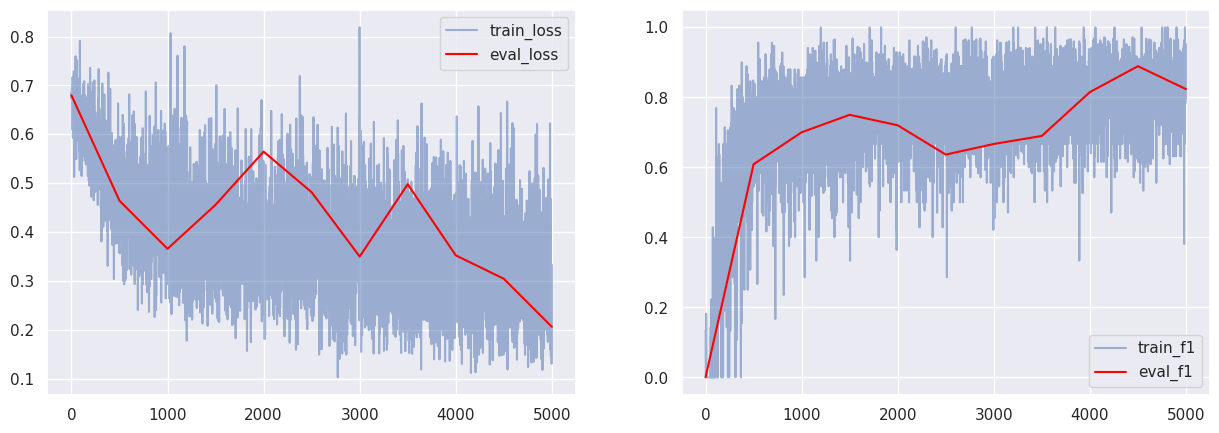

 20%|██        | 314/1562 [00:21<01:26, 14.37it/s]


In [137]:
training_loop_fn(model, 5000, 500, train_loader, valid_loader)

### Testing the model

In [160]:
# Function to check similarity
@torch.no_grad()
def check_similarity(question1, question2, target=0):
    tokenizer_output = tokenizer(question1, question2, truncation=True, max_length=32, return_tensors='pt')
    logits = model(**{key: tokenizer_output[key].to(device) for key in keys}).logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    
    predicted_class_id = int(torch.argmax(logits, dim=-1))
    print(f"question1: {question1}")
    print(f"question2: {question2}")
    print(f"target: {target}, pred: {predicted_class_id}")
    print("probs:", probs.cpu().numpy())

In [161]:
# Checking similarity between two questions
check_similarity("Why are people so obsessed with cricket?", "Why are people so obsessed with football?", 1)

question1: Why are people so obsessed with cricket?
question2: Why are people so obsessed with football?
target: 1, pred: 0
probs: [[0.9798695  0.02013048]]


In [162]:
# Checking similarity between two questions
check_similarity("Why are people so obsessed with cricket?", "Why do people like cricket?", 1)

question1: Why are people so obsessed with cricket?
question2: Why do people like cricket?
target: 1, pred: 0
probs: [[0.546093 0.453907]]


In [163]:
for i in range(10):
    question1 = valid_dataset[i]["question1"]
    question2 = valid_dataset[i]["question2"]
    label = valid_dataset[i]["label"]
    check_similarity(question1, question2, label)
    print()

question1: Why are African-Americans so beautiful?
question2: Why are hispanics so beautiful?
target: 0, pred: 0
probs: [[0.8423751  0.15762492]]

question1: I want to pursue PhD in Computer Science about social network,what is the open problem in social networks?
question2: I handle social media for a non-profit. Should I start going to social media networking events? Are there any good ones in the bay area?
target: 0, pred: 0
probs: [[0.9823934  0.01760667]]

question1: Is there a reason why we should travel alone?
question2: What are some reasons to travel alone?
target: 1, pred: 1
probs: [[0.06970244 0.9302975 ]]

question1: Why are people so obsessed with having a girlfriend/boyfriend?
question2: How can a single male have a child?
target: 0, pred: 0
probs: [[0.9812176  0.01878241]]

question1: What are some good baby girl names starting with D?
question2: What are some good baby girl names starting with D or H?
target: 0, pred: 1
probs: [[0.31852606 0.681474  ]]

question1: I am 